In [1]:
from adjustText import adjust_text
from google.cloud import spanner
from sklearn import metrics
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

In [2]:
spanner_client = spanner.Client()
instance = spanner_client.instance('ml-models-characterization-db')
database = instance.database('models_db')

In [3]:
num_models = dict()
with database.snapshot() as snapshot:
    results = snapshot.execute_sql(
        'SELECT sub_category, COUNT(model_name) as count'
        ' FROM Models'
        ' WHERE model_type = "canonical"'
        ' GROUP BY sub_category'
    )
    
for row in results:
    num_models[row[0]] = row[1]
    
print(num_models)

{'TextClassification': 2, 'ImageGeneration': 4, 'ImageSegmentation': 5, 'PalmDetection': 1, 'ImageObjectDetection': 7, 'AutomaticSpeechRecognition': 1, 'FaceDetection': 2, 'ImageStyleTransfer': 1, 'AudioPitchExtraction': 1, 'TextGeneration': 3, 'ImagePoseDetection': 1, 'TextRetrievalQuestionAnswering': 2, 'TextEmbedding': 3, 'ImageOthers': 1, 'ImageFeatureVector': 1, 'ImageClassification': 16}


In [4]:
with database.snapshot() as snapshot:
    results = snapshot.execute_sql(
        'SELECT Models.model_name, COUNT(operator_type)'
        ' FROM Models JOIN Operators'
        ' ON Models.model_name = Operators.model_name'
        ' WHERE model_type = "canonical"'
        ' GROUP BY model_name'
        ' ORDER BY model_name'
    )
    
total_ops = dict()
for row in results:
    total_ops[row[0]] = row[1]
    
print(total_ops)

{'albert_lite_base_squadv1_1': 2682, 'bigbigan-resnet50_1': 1590, 'biggan-128_2': 212, 'biggan-deep-128_1': 586, 'bvlcalexnet': 74, 'caffenet': 68, 'compare_gan_model_15_cifar10_resnet_cifar_1': 2892, 'context_rcnn_resnet101_snapshot_serengeti_2020_06_10': 2204, 'cord-19_swivel-128d_3': 76, 'deeplabv3_1_default_1': 72, 'deepspeech-0.7.4': 232, 'delf_1': 491, 'densenet': 251, 'distilbert-base-uncased-distilled-squad-384': 1294, 'distilgpt2-64': 1102, 'efficientnet_b5_feature-vector_1': 1110, 'electra-small-finetuned-imdb': 1527, 'gpt2-64': 2188, 'inception_resnet_v2': 258, 'inception_v1_224_quant': 85, 'inception_v2_224_quant': 98, 'inception_v3_quant': 127, 'inception_v4_299_quant': 197, 'koelectra-small-finetuned-sentiment': 1527, 'koelectra-small-v2-distilled-korquad-384': 1537, 'lite-model_deeplabv3-mobilenetv2_1_default_1': 111, 'lite-model_deeplabv3-mobilenetv3-cityscapes_1_default_1': 131, 'lite-model_deeplabv3-xception65-cityscapes_1_default_1': 428, 'lite-model_on_device_vision

In [5]:
with database.snapshot() as snapshot:
    results = snapshot.execute_sql(
        'SELECT Models.model_name, COUNT(operator_type) as count'
        ' FROM Models JOIN Operators'
        ' ON Models.model_name = Operators.model_name'
        ' WHERE operator_type = "Conv2D" and model_type = "canonical"'
        ' GROUP BY model_name'
        ' ORDER BY count DESC;'
    )
    
conv2d_ops_percent = dict()
for row in results:
    conv2d_ops_percent[row[0]] = row[1] / total_ops[row[0]]

conv2d_ops_percent = {key: value for key, value in 
                      sorted(conv2d_ops_percent.items(), 
                             key=lambda item: item[1], reverse = True)}
    
print(conv2d_ops_percent)

{'inception_v4_299_quant': 0.7563451776649747, 'inception_v3_quant': 0.7480314960629921, 'inception_resnet_v2': 0.7286821705426356, 'inception_v2_224_quant': 0.7142857142857143, 'inception_v1_224_quant': 0.6823529411764706, 'squeezenet': 0.6190476190476191, 'magenta_arbitrary-image-stylization-v1-256_fp16_prediction_1': 0.5454545454545454, 'mobilenet_v2_1.0_224_quant': 0.5373134328358209, 'mnasnet_1.3_224': 0.5303030303030303, 'deeplabv3_1_default_1': 0.5277777777777778, 'ssdlite_mobiledet_dsp_320x320_coco_2020_05_19': 0.5038167938931297, 'posenet_mobilenet_float_075_1_default_1': 0.5, 'ssd_mobilenet_v1_1_default_1': 0.4927536231884058, 'mediapipe_object_detection_3d_sneakers': 0.4838709677419355, 'resnet_v2_101_299': 0.481651376146789, 'object_detection_mobile_object_localizer_v1_1_default_1': 0.4583333333333333, 'mobilenet_v1_1.0_224': 0.45454545454545453, 'lite-model_deeplabv3-mobilenetv3-cityscapes_1_default_1': 0.3893129770992366, 'ssd_mobilenet_v3_small_coco_2020_01_14': 0.358823

In [6]:
labels = list(conv2d_ops_percent.keys())
values = list()
for label in labels:
    if label not in conv2d_ops_percent:
        values.append(0)
        continue
    values.append(conv2d_ops_percent[label] * 100)

labels = labels[:-len(labels) + 20]
values = values[:-len(values) + 20]

print(labels)
print(values)

['inception_v4_299_quant', 'inception_v3_quant', 'inception_resnet_v2', 'inception_v2_224_quant', 'inception_v1_224_quant', 'squeezenet', 'magenta_arbitrary-image-stylization-v1-256_fp16_prediction_1', 'mobilenet_v2_1.0_224_quant', 'mnasnet_1.3_224', 'deeplabv3_1_default_1', 'ssdlite_mobiledet_dsp_320x320_coco_2020_05_19', 'posenet_mobilenet_float_075_1_default_1', 'ssd_mobilenet_v1_1_default_1', 'mediapipe_object_detection_3d_sneakers', 'resnet_v2_101_299', 'object_detection_mobile_object_localizer_v1_1_default_1', 'mobilenet_v1_1.0_224', 'lite-model_deeplabv3-mobilenetv3-cityscapes_1_default_1', 'ssd_mobilenet_v3_small_coco_2020_01_14', 'ssd_mobilenet_v3_large_coco_2020_01_14']
[75.63451776649747, 74.80314960629921, 72.86821705426357, 71.42857142857143, 68.23529411764706, 61.904761904761905, 54.54545454545454, 53.73134328358209, 53.03030303030303, 52.77777777777778, 50.38167938931297, 50.0, 49.275362318840585, 48.38709677419355, 48.1651376146789, 45.83333333333333, 45.45454545454545,

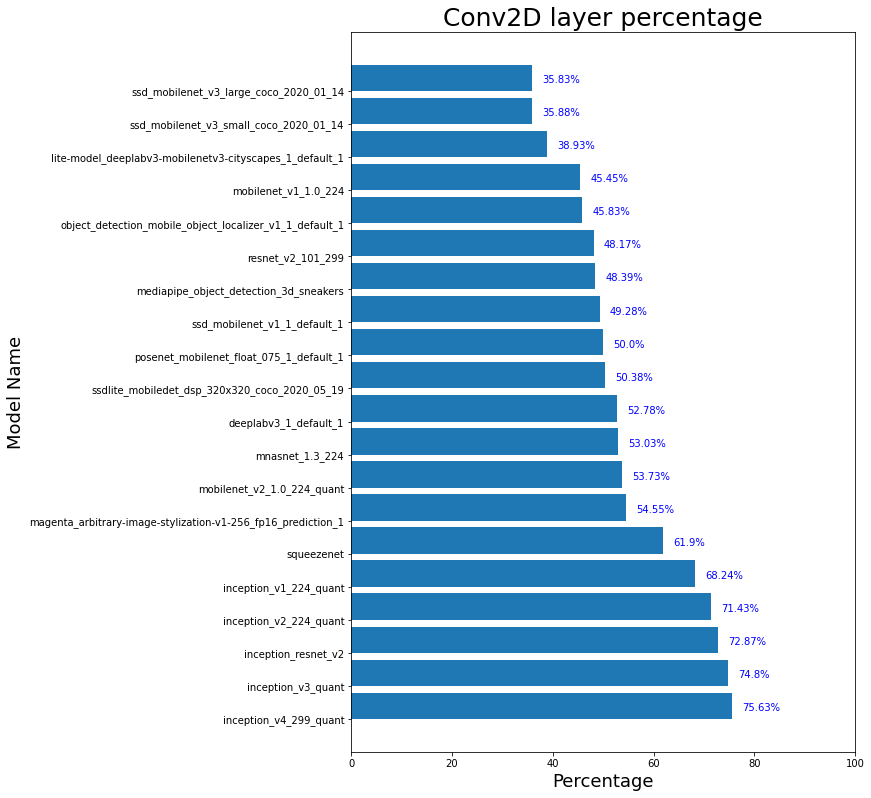

In [7]:
fig = plt.figure(figsize = (7,10))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Conv2D layer percentage", fontsize = 25)
ax.set_xlim([0, 100])
plt.barh(labels, values, align='edge')
ax.set_xlabel('Percentage', fontsize = 18)
ax.set_ylabel('Model Name', fontsize = 18)

for index, value in enumerate(values):
    ax.text(value + 2, index + .25, str(round(value,2)) + "%", color='blue')

plt.show()

In [8]:
with database.snapshot() as snapshot:
    results = snapshot.execute_sql(
        'SELECT sub_category, operator_type, COUNT(operator_id) as count'
        ' FROM Models JOIN Operators'
        ' ON Models.model_name = Operators.model_name'
        ' WHERE operator_type NOT IN ("Output_Placeholder", "Placeholder", "Input_Placeholder")'
        ' AND model_type = "canonical" and source = "TFLite"'
        ' GROUP BY sub_category, operator_type'
        ' ORDER BY sub_category, count DESC;'
    )
    
category_op_dist = dict()
category_total_ops = dict()

categories = list()

for row in results:
    if row[0] not in categories:
        op_dist = dict()        
        categories.append(row[0])
    op_dist[row[1]] = row[2]
    category_op_dist[row[0]] = op_dist
    
    if row[0] not in category_total_ops:
        category_total_ops[row[0]] = 0

    category_total_ops[row[0]] += row[2]

print(category_op_dist['ImageClassification'])
print(category_op_dist['TextEmbedding'])
print(category_total_ops)

{'Conv2D': 1351, 'DepthwiseConv2dNative': 443, 'Add': 396, 'Relu': 266, 'Concat': 204, 'AveragePool': 165, 'Mul': 122, 'MaxPool': 53, 'Split': 38, 'HardSwish': 21, 'Mean': 14, 'Pad': 12, 'Reshape': 9, 'Softmax': 8, 'FULLY_CONNECTED': 8, 'StridedSlice': 8, 'Gather': 2, 'Squeeze': 2, 'Pow': 2, 'Prod': 2, 'Maximum': 1, 'Shape': 1, 'Cast': 1, 'Transpose': 1, 'L2_NORMALIZATION': 1, 'Dequantize': 1, 'Pack': 1, 'QUANTIZE': 1}
{'Reshape': 1406, 'Slice': 1010, 'FULLY_CONNECTED': 941, 'Transpose': 663, 'Add': 500, 'Mul': 330, 'Pack': 146, 'Sub': 50, 'Mean': 50, 'Softmax': 36, 'SquaredDifference': 25, 'Rsqrt': 25, 'Tanh': 12, 'Pow': 12, 'Gather': 4, 'Unpack': 2, 'Cast': 2, 'StridedSlice': 2, 'Pad': 2, 'Concat': 1}
{'AudioPitchExtraction': 303, 'AutomaticSpeechRecognition': 224, 'FaceDetection': 234, 'ImageClassification': 3134, 'ImageObjectDetection': 772, 'ImagePoseDetection': 33, 'ImageSegmentation': 993, 'ImageStyleTransfer': 64, 'PalmDetection': 193, 'TextClassification': 3048, 'TextEmbedding

sum 3134


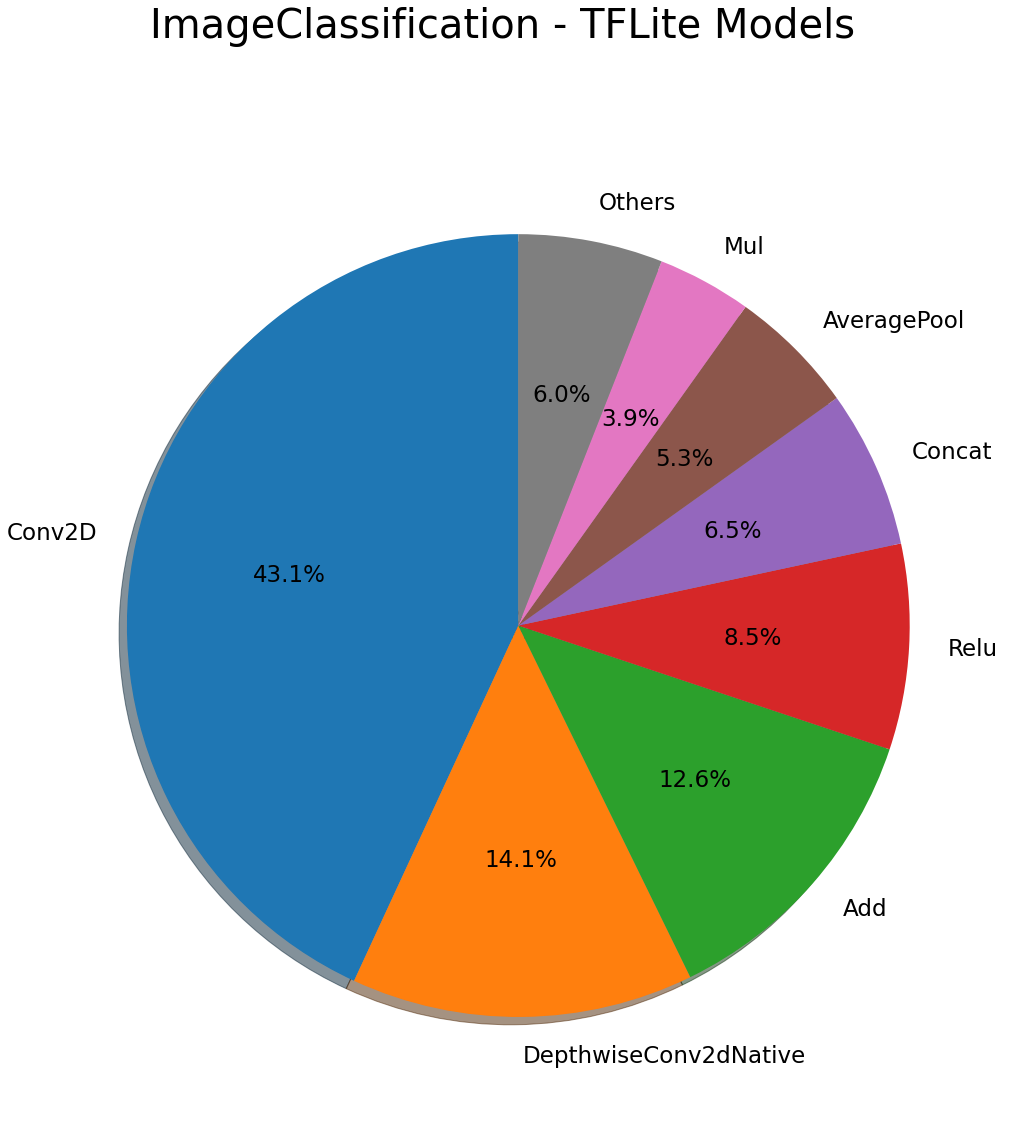

sum 772


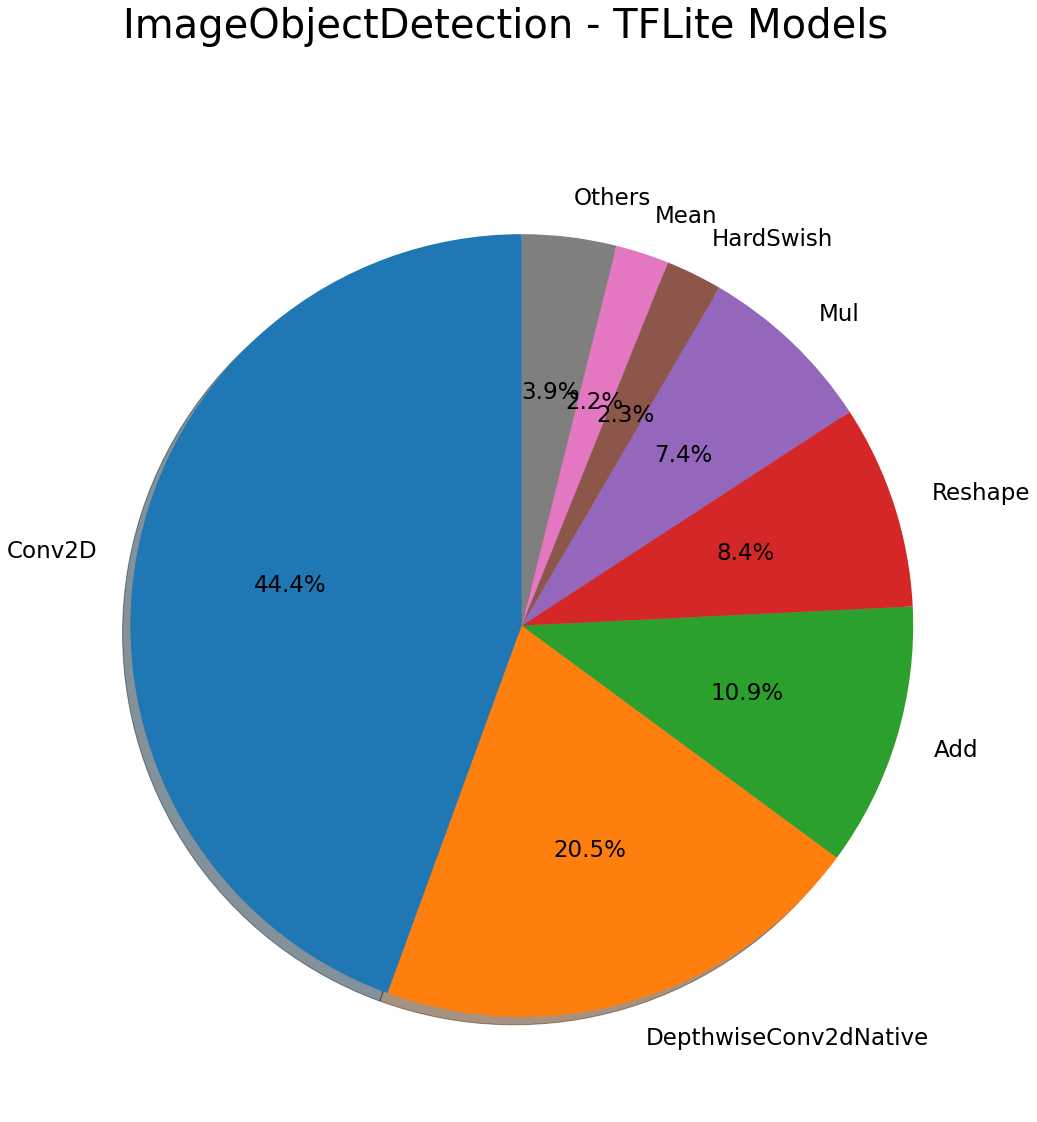

sum 993


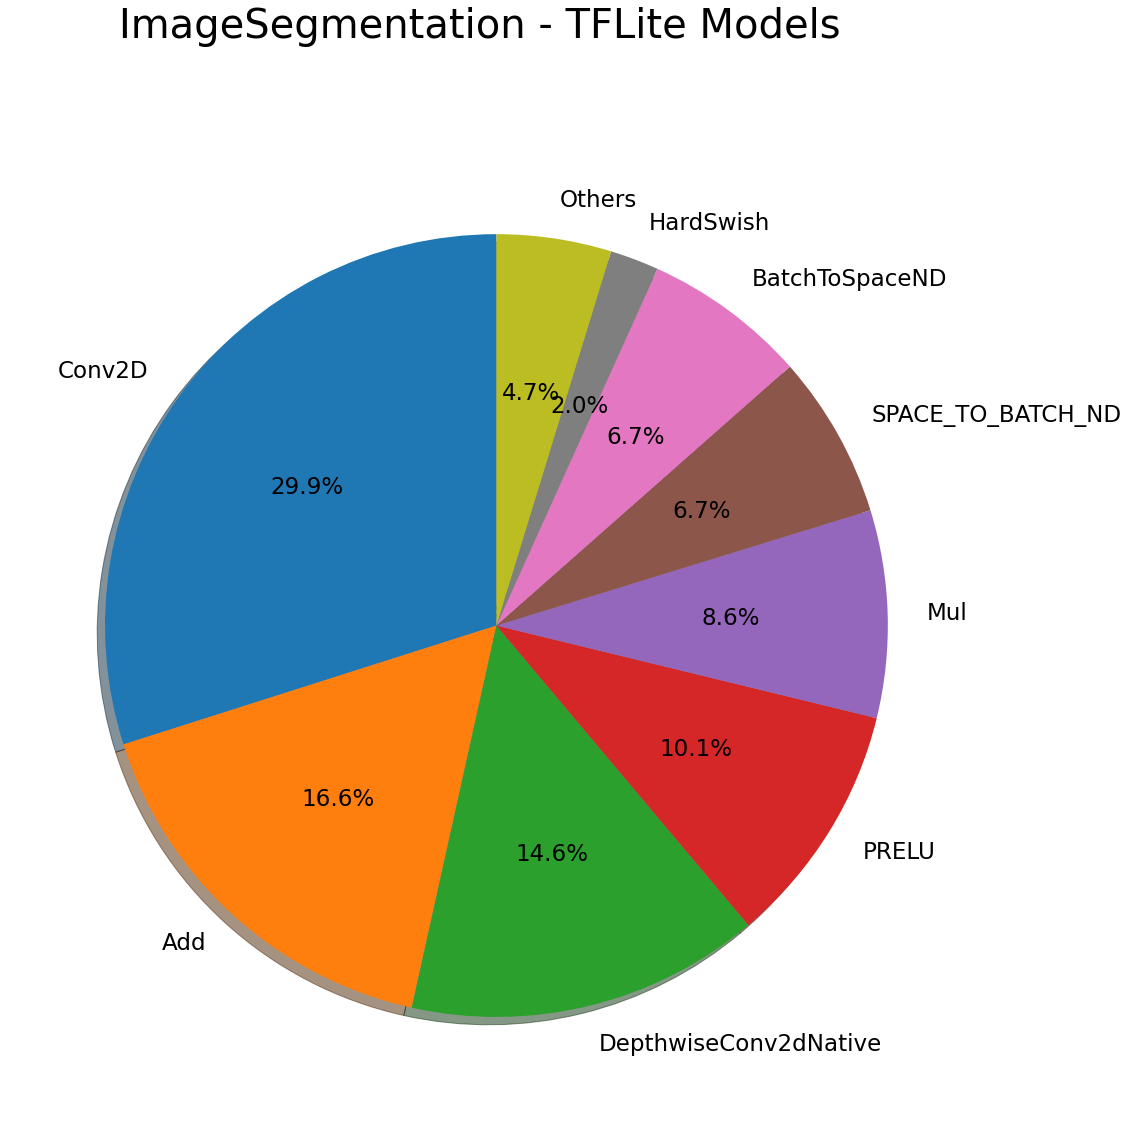

sum 5219


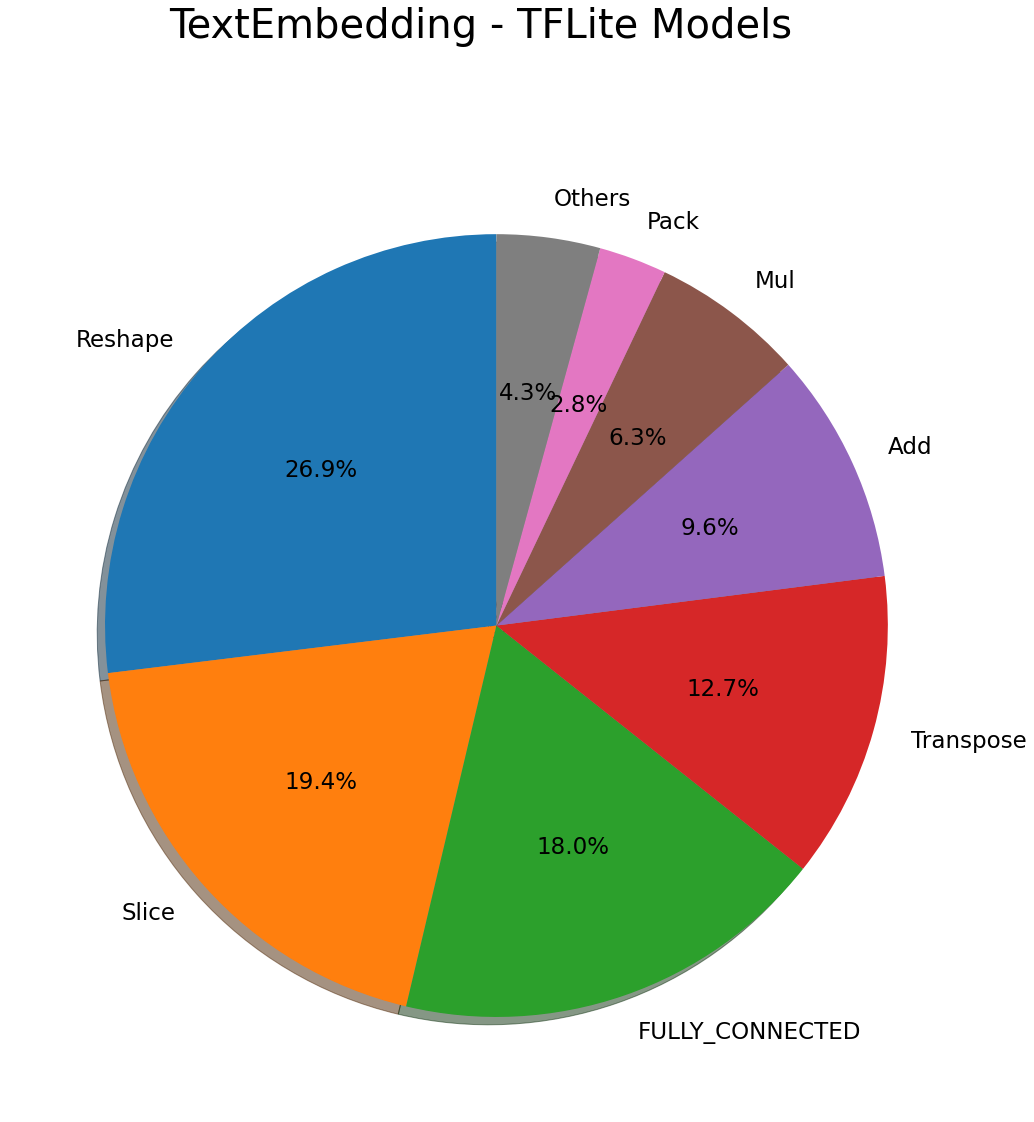

sum 3274


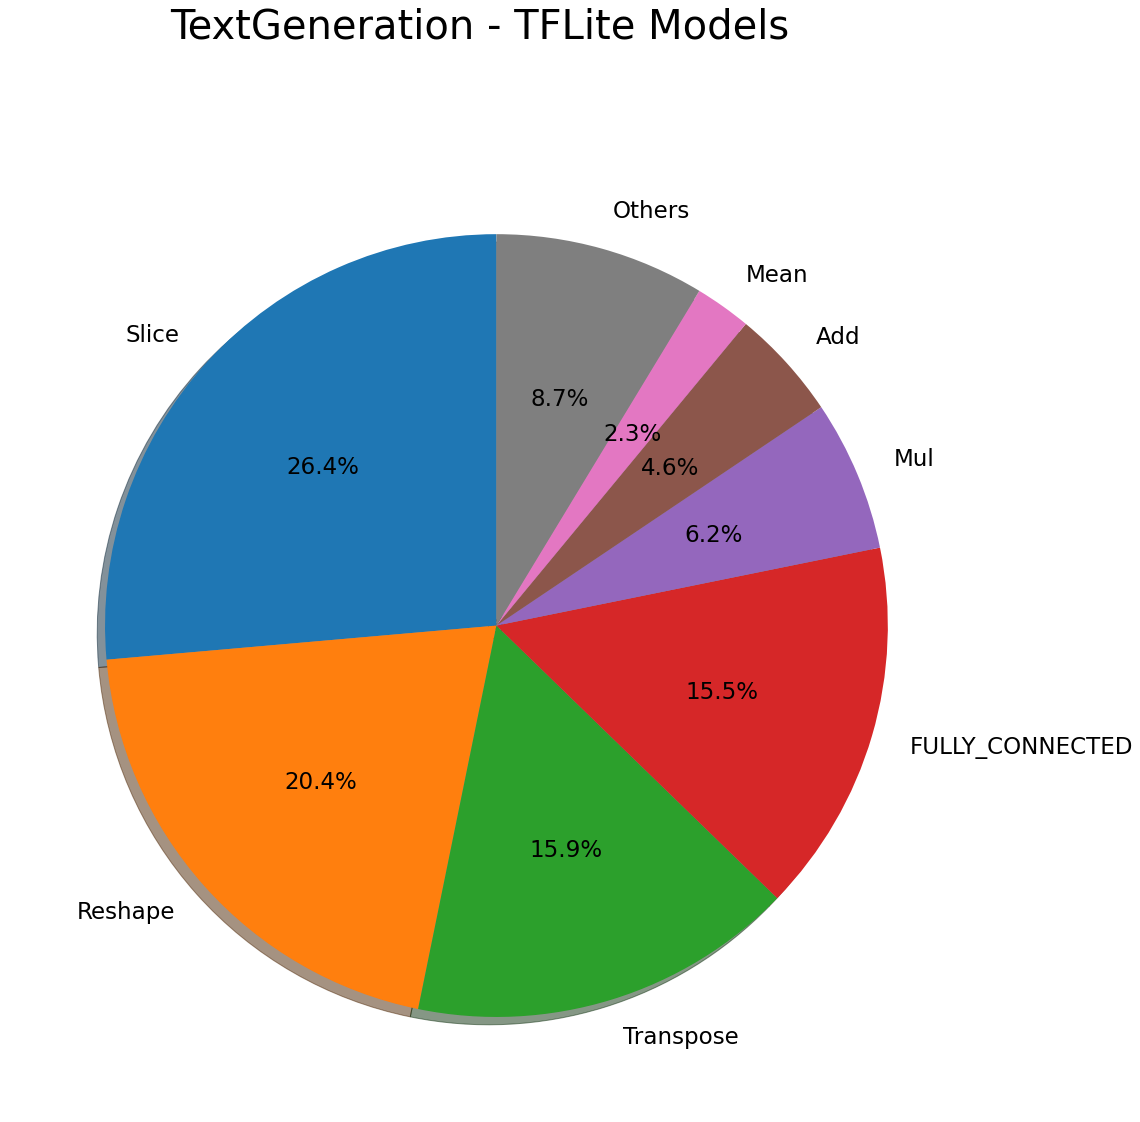

In [9]:
for category in categories:
    if(num_models[category] >= 3):
        labels = list(category_op_dist[category].keys())
        values = list(category_op_dist[category].values())

        sum_values = sum(values)
        print("sum" , sum_values)

        cumm_val = 0
        for index in reversed(range(len(labels))):
            if values[index] / sum_values > 0.02:
                break

            cumm_val += values[index]
            values.pop(index)
            labels.pop(index)


        if cumm_val != 0:
            labels.append("Others")
            values.append(cumm_val)

        fig, ax = plt.subplots(figsize = (18, 18))

        ax.pie(values, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 23})
        fig.suptitle(category + " - TFLite Models", fontsize = '40')
        plt.show()

In [10]:
with database.snapshot() as snapshot:
    results = snapshot.execute_sql(
        'SELECT sub_category, operator_type, COUNT(operator_id) as count'
        ' FROM Models JOIN Operators'
        ' ON Models.model_name = Operators.model_name'
        ' WHERE operator_type NOT IN ("Output_Placeholder", "Placeholder", "Input_Placeholder")'
        ' AND model_type = "canonical" and source = "TF"'
        ' GROUP BY sub_category, operator_type'
        ' ORDER BY sub_category, count DESC;'
    )
    
category_op_dist = dict()
category_total_ops = dict()

categories = list()

for row in results:
    if row[0] not in categories:
        op_dist = dict()        
        categories.append(row[0])
    op_dist[row[1]] = row[2]
    category_op_dist[row[0]] = op_dist
    
    if row[0] not in category_total_ops:
        category_total_ops[row[0]] = 0

    category_total_ops[row[0]] += row[2]

print(category_total_ops)

{'ImageClassification': 140, 'ImageFeatureVector': 1790, 'ImageGeneration': 5270, 'ImageObjectDetection': 2201, 'ImageOthers': 487, 'TextEmbedding': 74}


sum 140


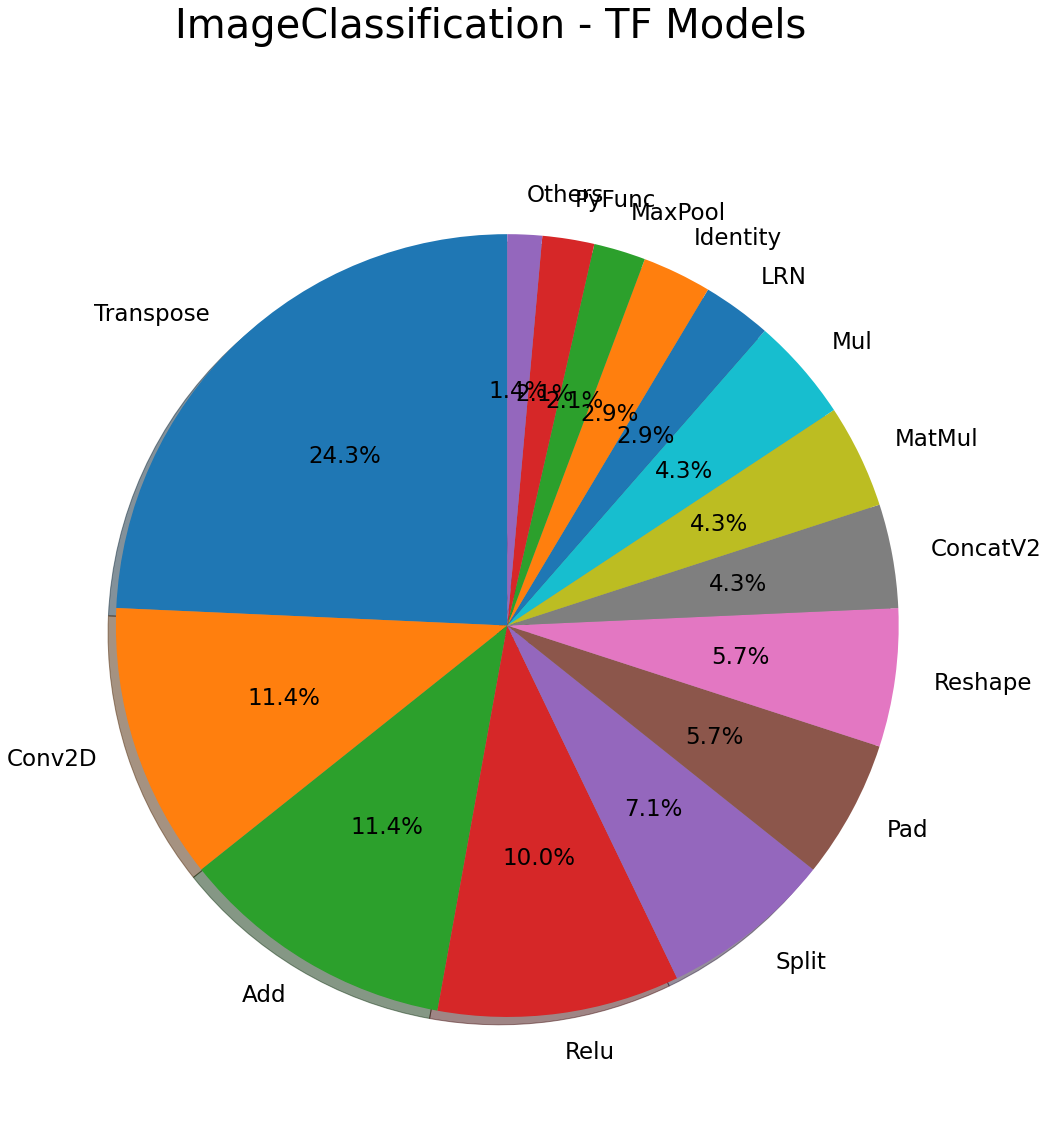

sum 5270


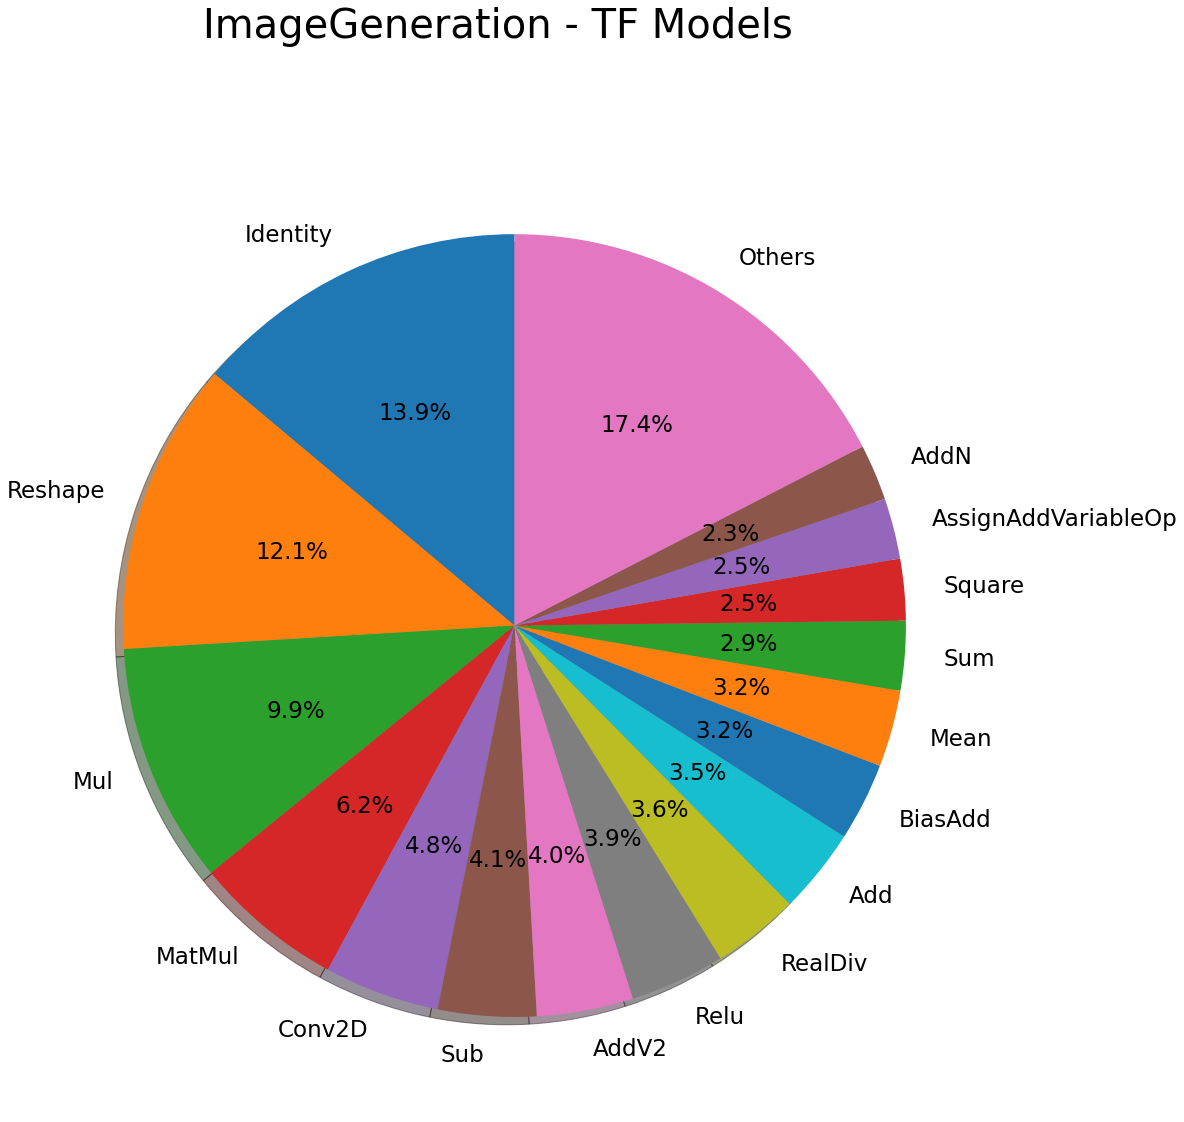

sum 2201


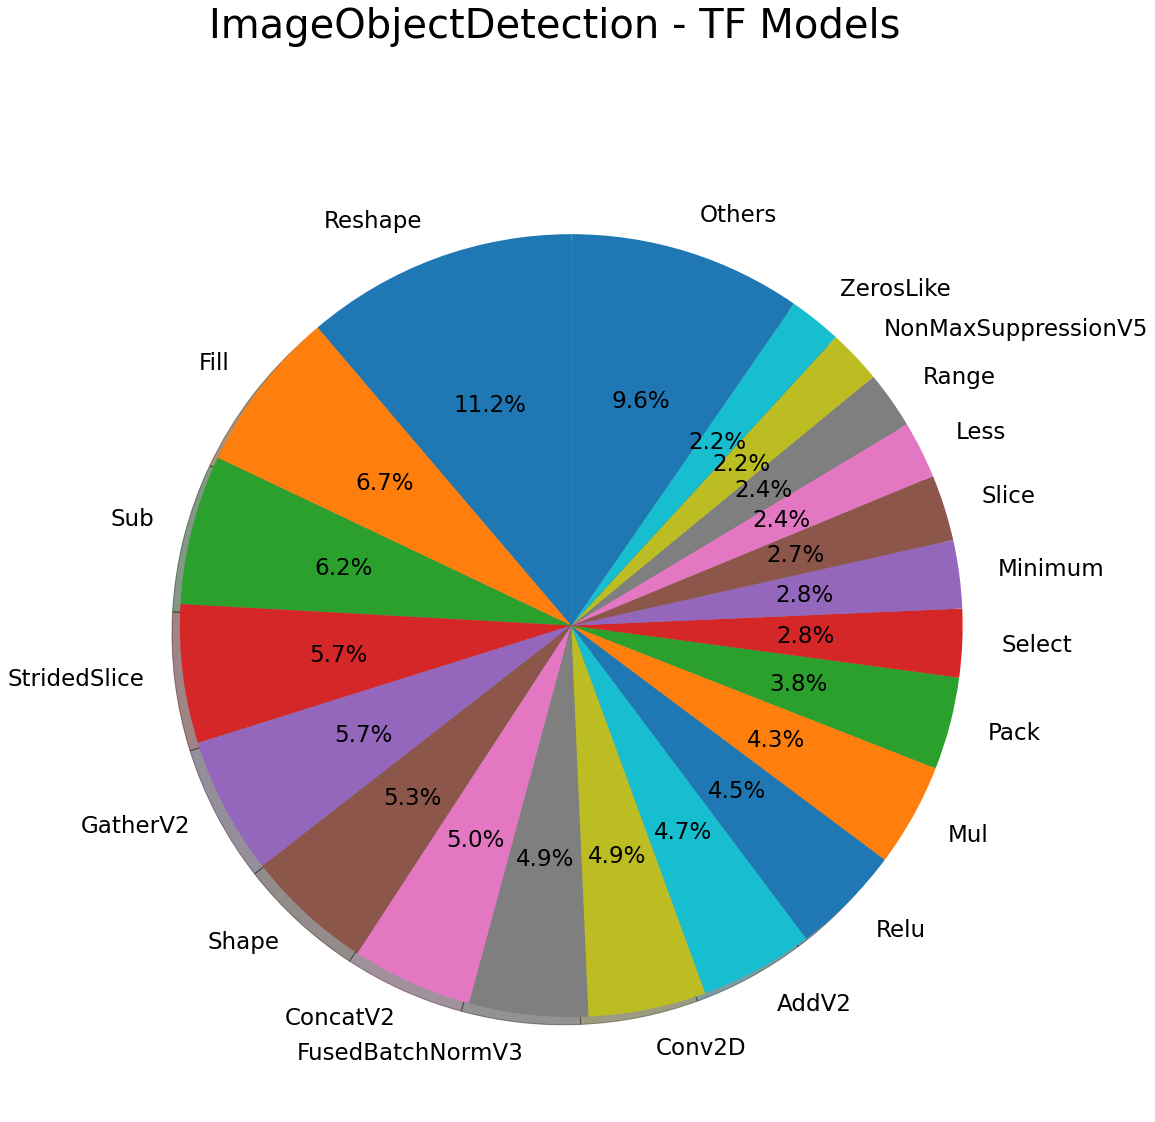

sum 74


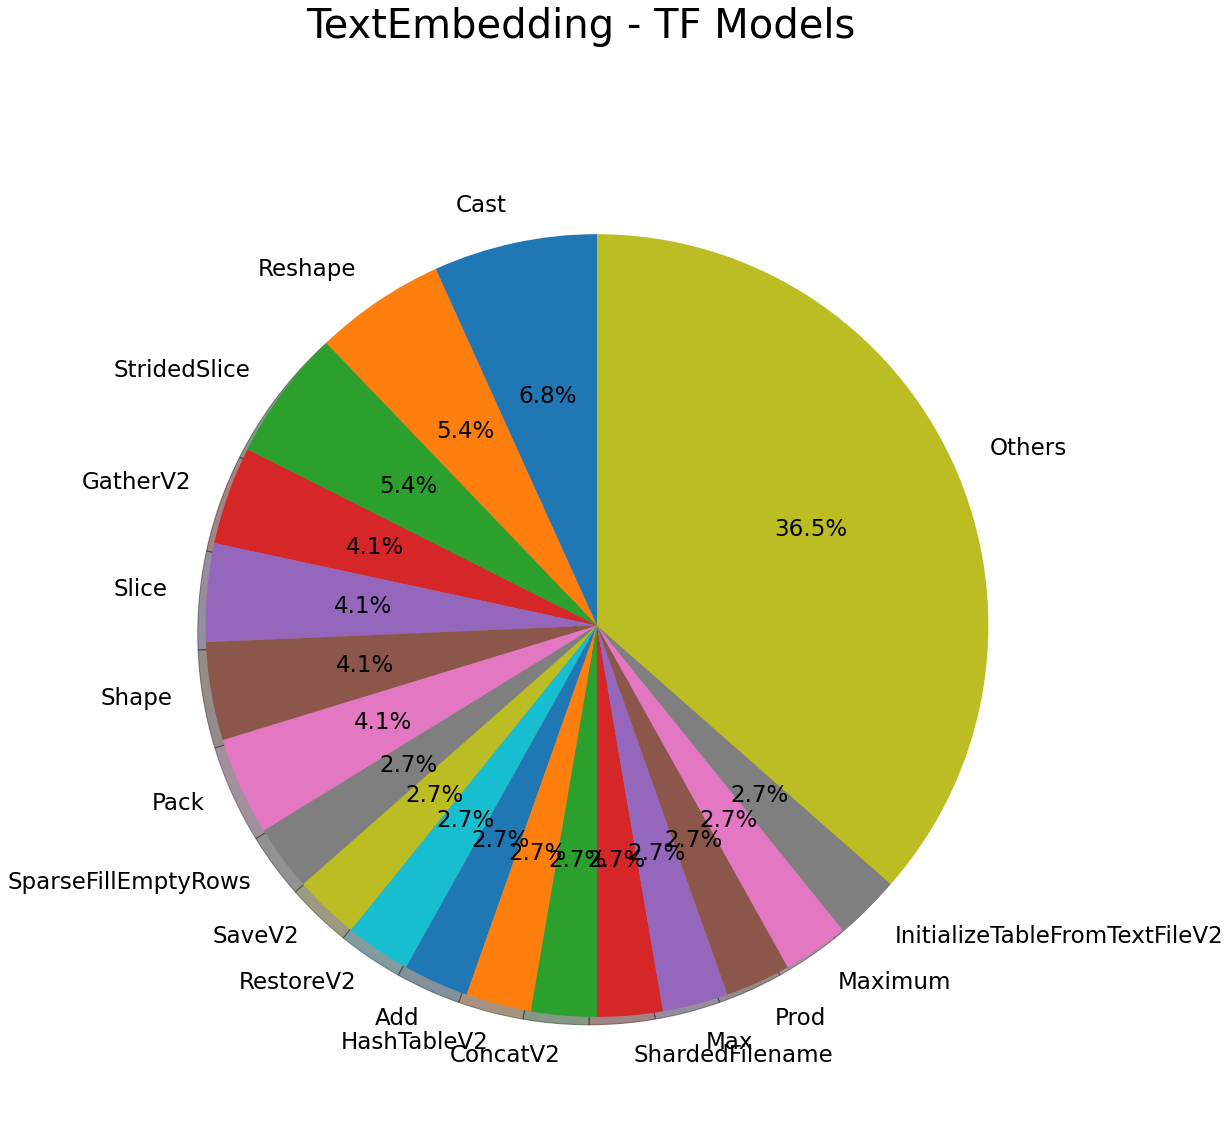

In [11]:
for category in categories:
    if(num_models[category] >= 3):
        labels = list(category_op_dist[category].keys())
        values = list(category_op_dist[category].values())

        sum_values = sum(values)
        print("sum" , sum_values)

        cumm_val = 0
        for index in reversed(range(len(labels))):
            if values[index] / sum_values > 0.02:
                break

            cumm_val += values[index]
            values.pop(index)
            labels.pop(index)


        if cumm_val != 0:
            labels.append("Others")
            values.append(cumm_val)

        fig, ax = plt.subplots(figsize = (18, 18))

        ax.pie(values, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 23})
        fig.suptitle(category + " - TF Models", fontsize = '40')
        plt.show()

In [12]:
with database.snapshot() as snapshot:
    results = snapshot.execute_sql(
        'SELECT operator_type, padding, COUNT(operator_id) as count'
        ' FROM Models JOIN Operators'
        ' ON Models.model_name = Operators.model_name'
        ' WHERE operator_type NOT IN ("Output_Placeholder", "Input_Placeholder")'
        ' AND padding IS NOT NULL and model_type = "canonical"'
        ' GROUP BY operator_type, padding'
        ' ORDER BY operator_type, count DESC;'
    )

In [13]:
operation_padding = dict()

for row in results:
    if row[0] not in operation_padding:
        operation_padding[row[0]] = dict()
        operation_padding[row[0]]['SAME'] = 0
        operation_padding[row[0]]['VALID'] = 0

    operation_padding[row[0]][row[1]] = row[2]
    

labels = list(operation_padding.keys())
same_pad_values = list()
valid_pad_values = list()

for label in labels:
    same_num = operation_padding[label]['SAME']
    valid_num = operation_padding[label]['VALID']
    total = same_num + valid_num
    same_pad_values.append(round((same_num / total) *  100))
    valid_pad_values.append(round((valid_num / total) * 100))

print(labels)
print(same_pad_values)
print(valid_pad_values)

['AveragePool', 'AvgPool', 'Conv2D', 'Conv2DBackpropInput', 'DepthwiseConv2dNative', 'MaxPool']
[79, 69, 77, 100, 92, 61]
[21, 31, 23, 0, 8, 39]


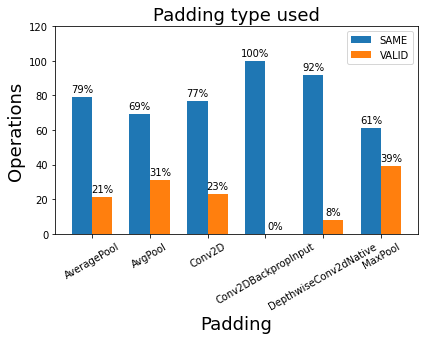

In [14]:
fig, ax = plt.subplots()

x = np.arange(len(labels))  # the label locations
width = 0.35
rects1 = ax.bar(x - width/2, same_pad_values, width, label='SAME')
rects2 = ax.bar(x + width/2, valid_pad_values, width, label='VALID')

ax.set_ylabel('Operations', fontsize = 18)
ax.set_xlabel('Padding', fontsize = 18)

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_title("Padding type used", fontsize = 18)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height) + "%",
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.xticks(rotation=30)

ax.set_ylim([0, 120])

plt.show()


In [15]:
with database.snapshot() as snapshot:
    results = snapshot.execute_sql(
        'SELECT activation_function, COUNT(operator_type) as count'
        ' FROM Models JOIN Operators'
        ' ON Models.model_name = Operators.model_name'
        ' WHERE activation_function IS NOT NULL AND activation_function != "NONE"'
        ' AND model_type = "canonical"'
        ' GROUP BY activation_function'
        ' ORDER BY count DESC;'
    )

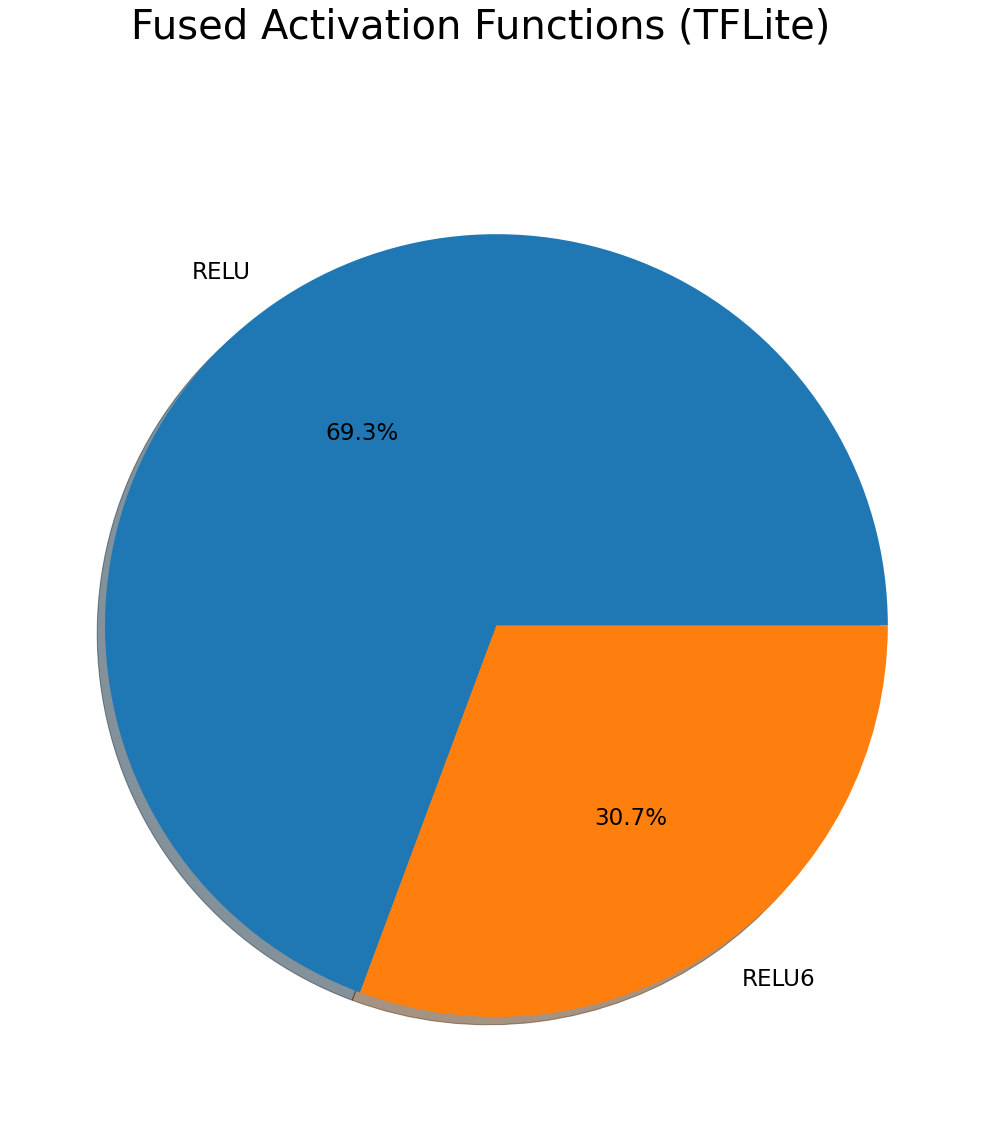

In [16]:
fused_activation_count = dict()
total_count = 0

for row in results:
    fused_activation_count[row[0]] = row[1]
    total_count += row[1]
    
labels = list(fused_activation_count.keys())
values = list(fused_activation_count.values())

fig, ax = plt.subplots(figsize = (18, 18))
ax.pie(values, labels = labels, autopct='%1.1f%%', shadow=True, startangle=0, textprops={'fontsize': 23})
fig.suptitle("Fused Activation Functions (TFLite)", fontsize = '40')
plt.show()

In [17]:
with database.snapshot() as snapshot:
    results = snapshot.execute_sql(
        'SELECT operator_type, COUNT(operator_id) as count'
        ' FROM Operators JOIN Models'
        ' ON Operators.model_name = Models.model_name'
        ' WHERE operator_type IN' 
        ' ("Relu", "Relu6", "Sigmoid", "Elu", "Selu", "Softplus", "Softsign", "Tanh", "Softmax")'
        ' AND model_type = "canonical"'
        ' GROUP BY operator_type'
        ' ORDER BY count DESC;'
    )

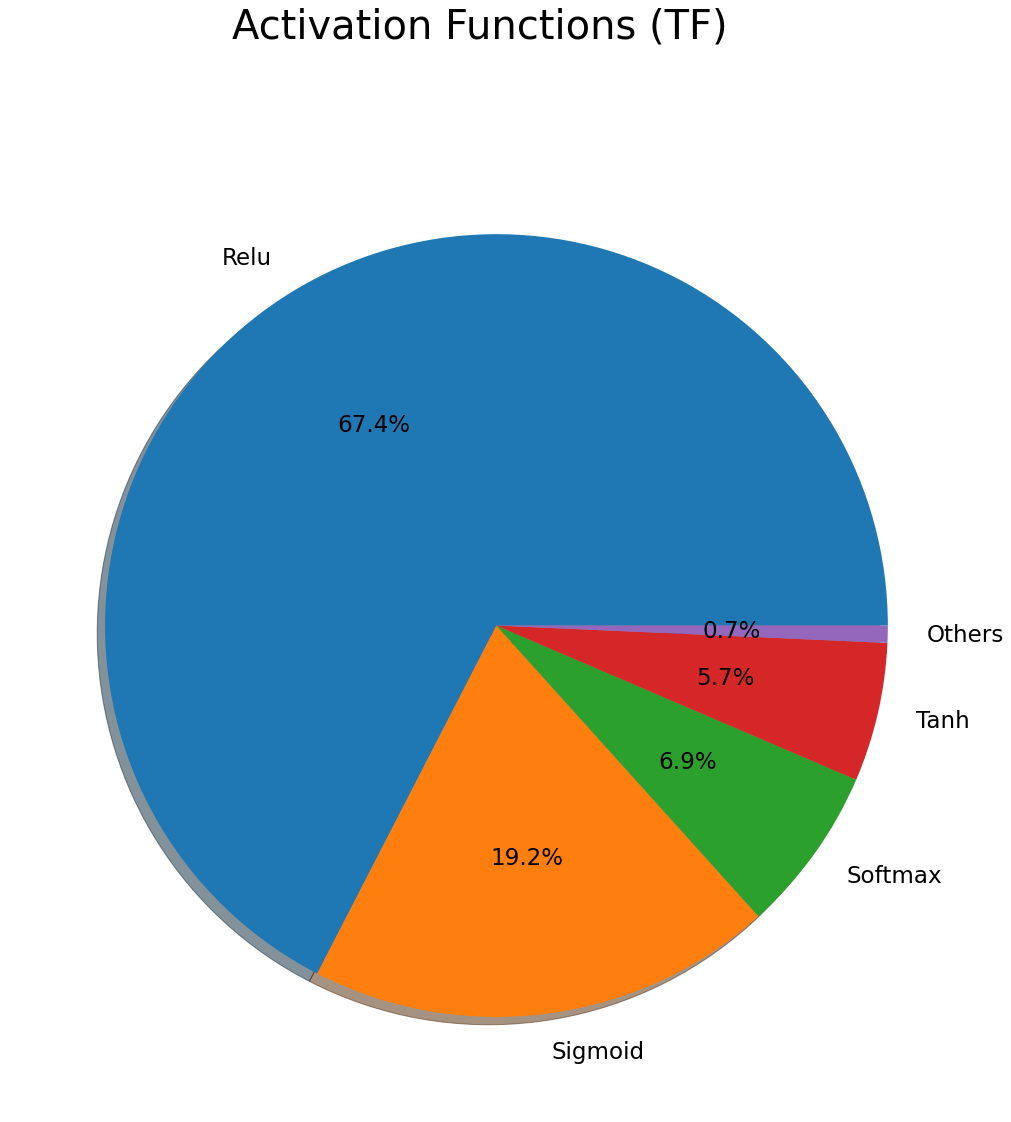

In [18]:
activation_count = dict()
total_count = 0

for row in results:
    activation_count[row[0]] = row[1]
    total_count += row[1]
    
labels = list(activation_count.keys())
values = list(activation_count.values())

others = 0

for index in reversed(range(len(values))):
    if values[index] / sum(values) <= 0.01 :
        others += values[index]
        values.pop(index)
        labels.pop(index)
        
values.append(others)
labels.append('Others')

fig, ax = plt.subplots(figsize = (18, 18))
ax.pie(values, labels = labels, autopct='%1.1f%%', shadow=True, startangle=0, textprops={'fontsize': 23})
fig.suptitle("Activation Functions (TF)", fontsize = '40')
plt.show()

In [19]:
with database.snapshot() as snapshot:
    results = snapshot.execute_sql(
        'SELECT category, operator_type, COUNT(operator_id) as count'
        ' FROM Models JOIN Operators ON Models.model_name = Operators.model_name'
        ' WHERE operator_type IN' 
        ' ("Relu", "Relu6", "Sigmoid", "Elu", "Selu", "Softplus", "Softsign", "Tanh", "Softmax")'
        ' and model_type = "canonical"'
        ' GROUP BY category, operator_type'
        ' ORDER BY count DESC;'
    )

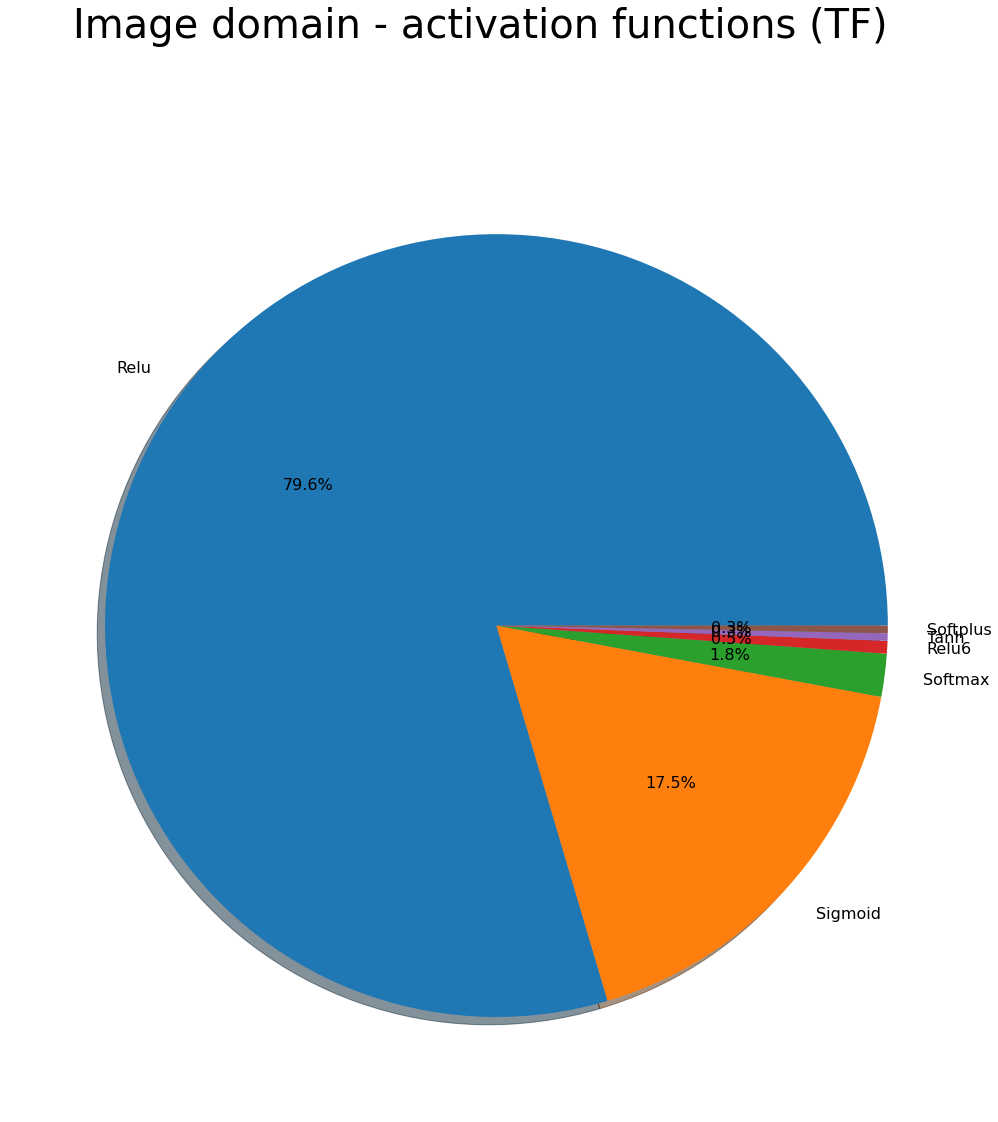

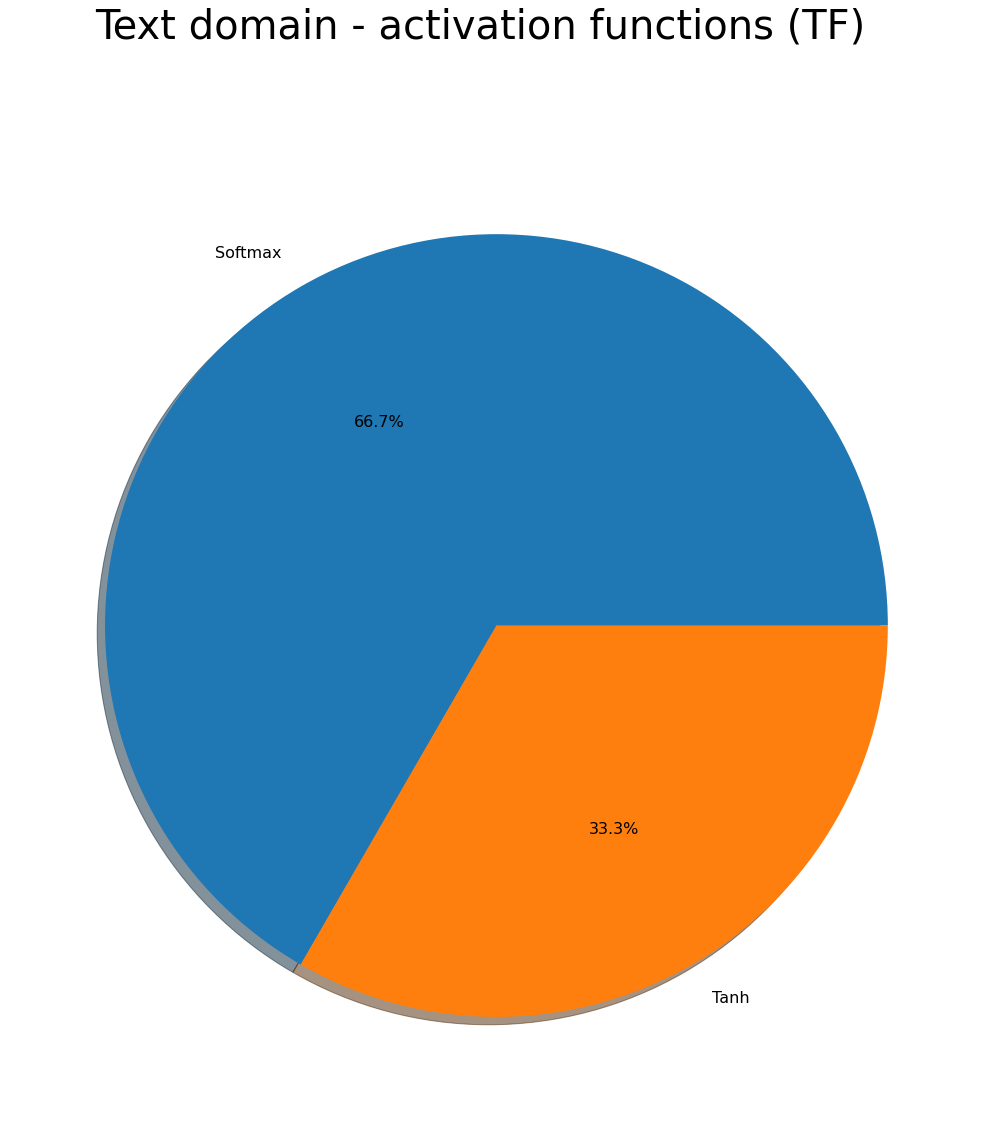

In [20]:
categories = list()
activation_data = dict()
activation_data.update({"Image" : dict()})
activation_data.update({"Text" : dict()})

for row in results:
    
    if "Image" in row[0] or row[0] == "ObjectDetection":
        if row[1] not in activation_data["Image"]:
            activation_data["Image"].update({row[1] : 0})
        activation_data["Image"][row[1]] += row[2]
    elif "Text" in row[0]:
        if row[1] not in activation_data["Text"]:
            activation_data["Text"].update({row[1] : 0})
        activation_data["Text"][row[1]] += row[2]

for key in activation_data.keys():
    
    labels = list(activation_data[key].keys())
    values = list(activation_data[key].values())
    
    fig, ax = plt.subplots(figsize = (18, 18))
    ax.pie(values, labels = labels,
           autopct='%1.1f%%', shadow=True, startangle=0, textprops={'fontsize': 16})
    fig.suptitle(key + " domain - activation functions (TF)", fontsize = '40')
    plt.show()

In [21]:
with database.snapshot() as snapshot:
    results = snapshot.execute_sql(
        'SELECT model_name, embeddings FROM Models WHERE embeddings IS NOT NULL'
    )
    
embeddings_data = dict()
for row in results:
    embeddings_data[row[0]] = row[1]

print(embeddings_data)

{'efficient_inception_module': [0.23475216, -1.0942357, 1.515015, -0.6638289, 1.1430026, 0.2613399, -0.9108846, -0.4776512, -0.8131312, -1.1562499, 0.58155036, 0.70177454, 0.27153754, -0.225872, -0.15674843, -0.34117815, -0.52473444, -1.0181504, 0.10572403, 0.37137106, -0.07246969, -0.34777486, -1.87779, 0.0828119, 0.47957504, -0.8701044, 0.047818065, 0.78282547, -1.3074517, 1.2766424, 0.14743152, 0.78034484, 0.2669716, 0.9224304, 1.771575, -1.0042995, 0.80266464, 0.076483436, -0.8504564, -0.2987769, 0.2546633, -1.1527653, -0.9813638, -0.23762323, 0.5143104, 0.38516095, -1.2771553, 0.12966053, 1.4043322, -0.75765336, 0.27328175, 0.7838513, -0.8938076, -0.6539477, -0.39327234, -0.102418244, -0.13906826, -0.9934266, -0.26258218, -1.3771181, 0.69231635, -0.089751504, -0.14432092, 1.6408831, 1.2668633, -1.3688992, 0.30746168, 0.42674756, 0.71699435, 1.225992, -0.5701152, -0.22003715, 0.4161069, 0.6998543, -0.3232154, 0.50631934, 0.069022216, -0.39476594, 0.41592005, 1.2095813, -0.5467071, 

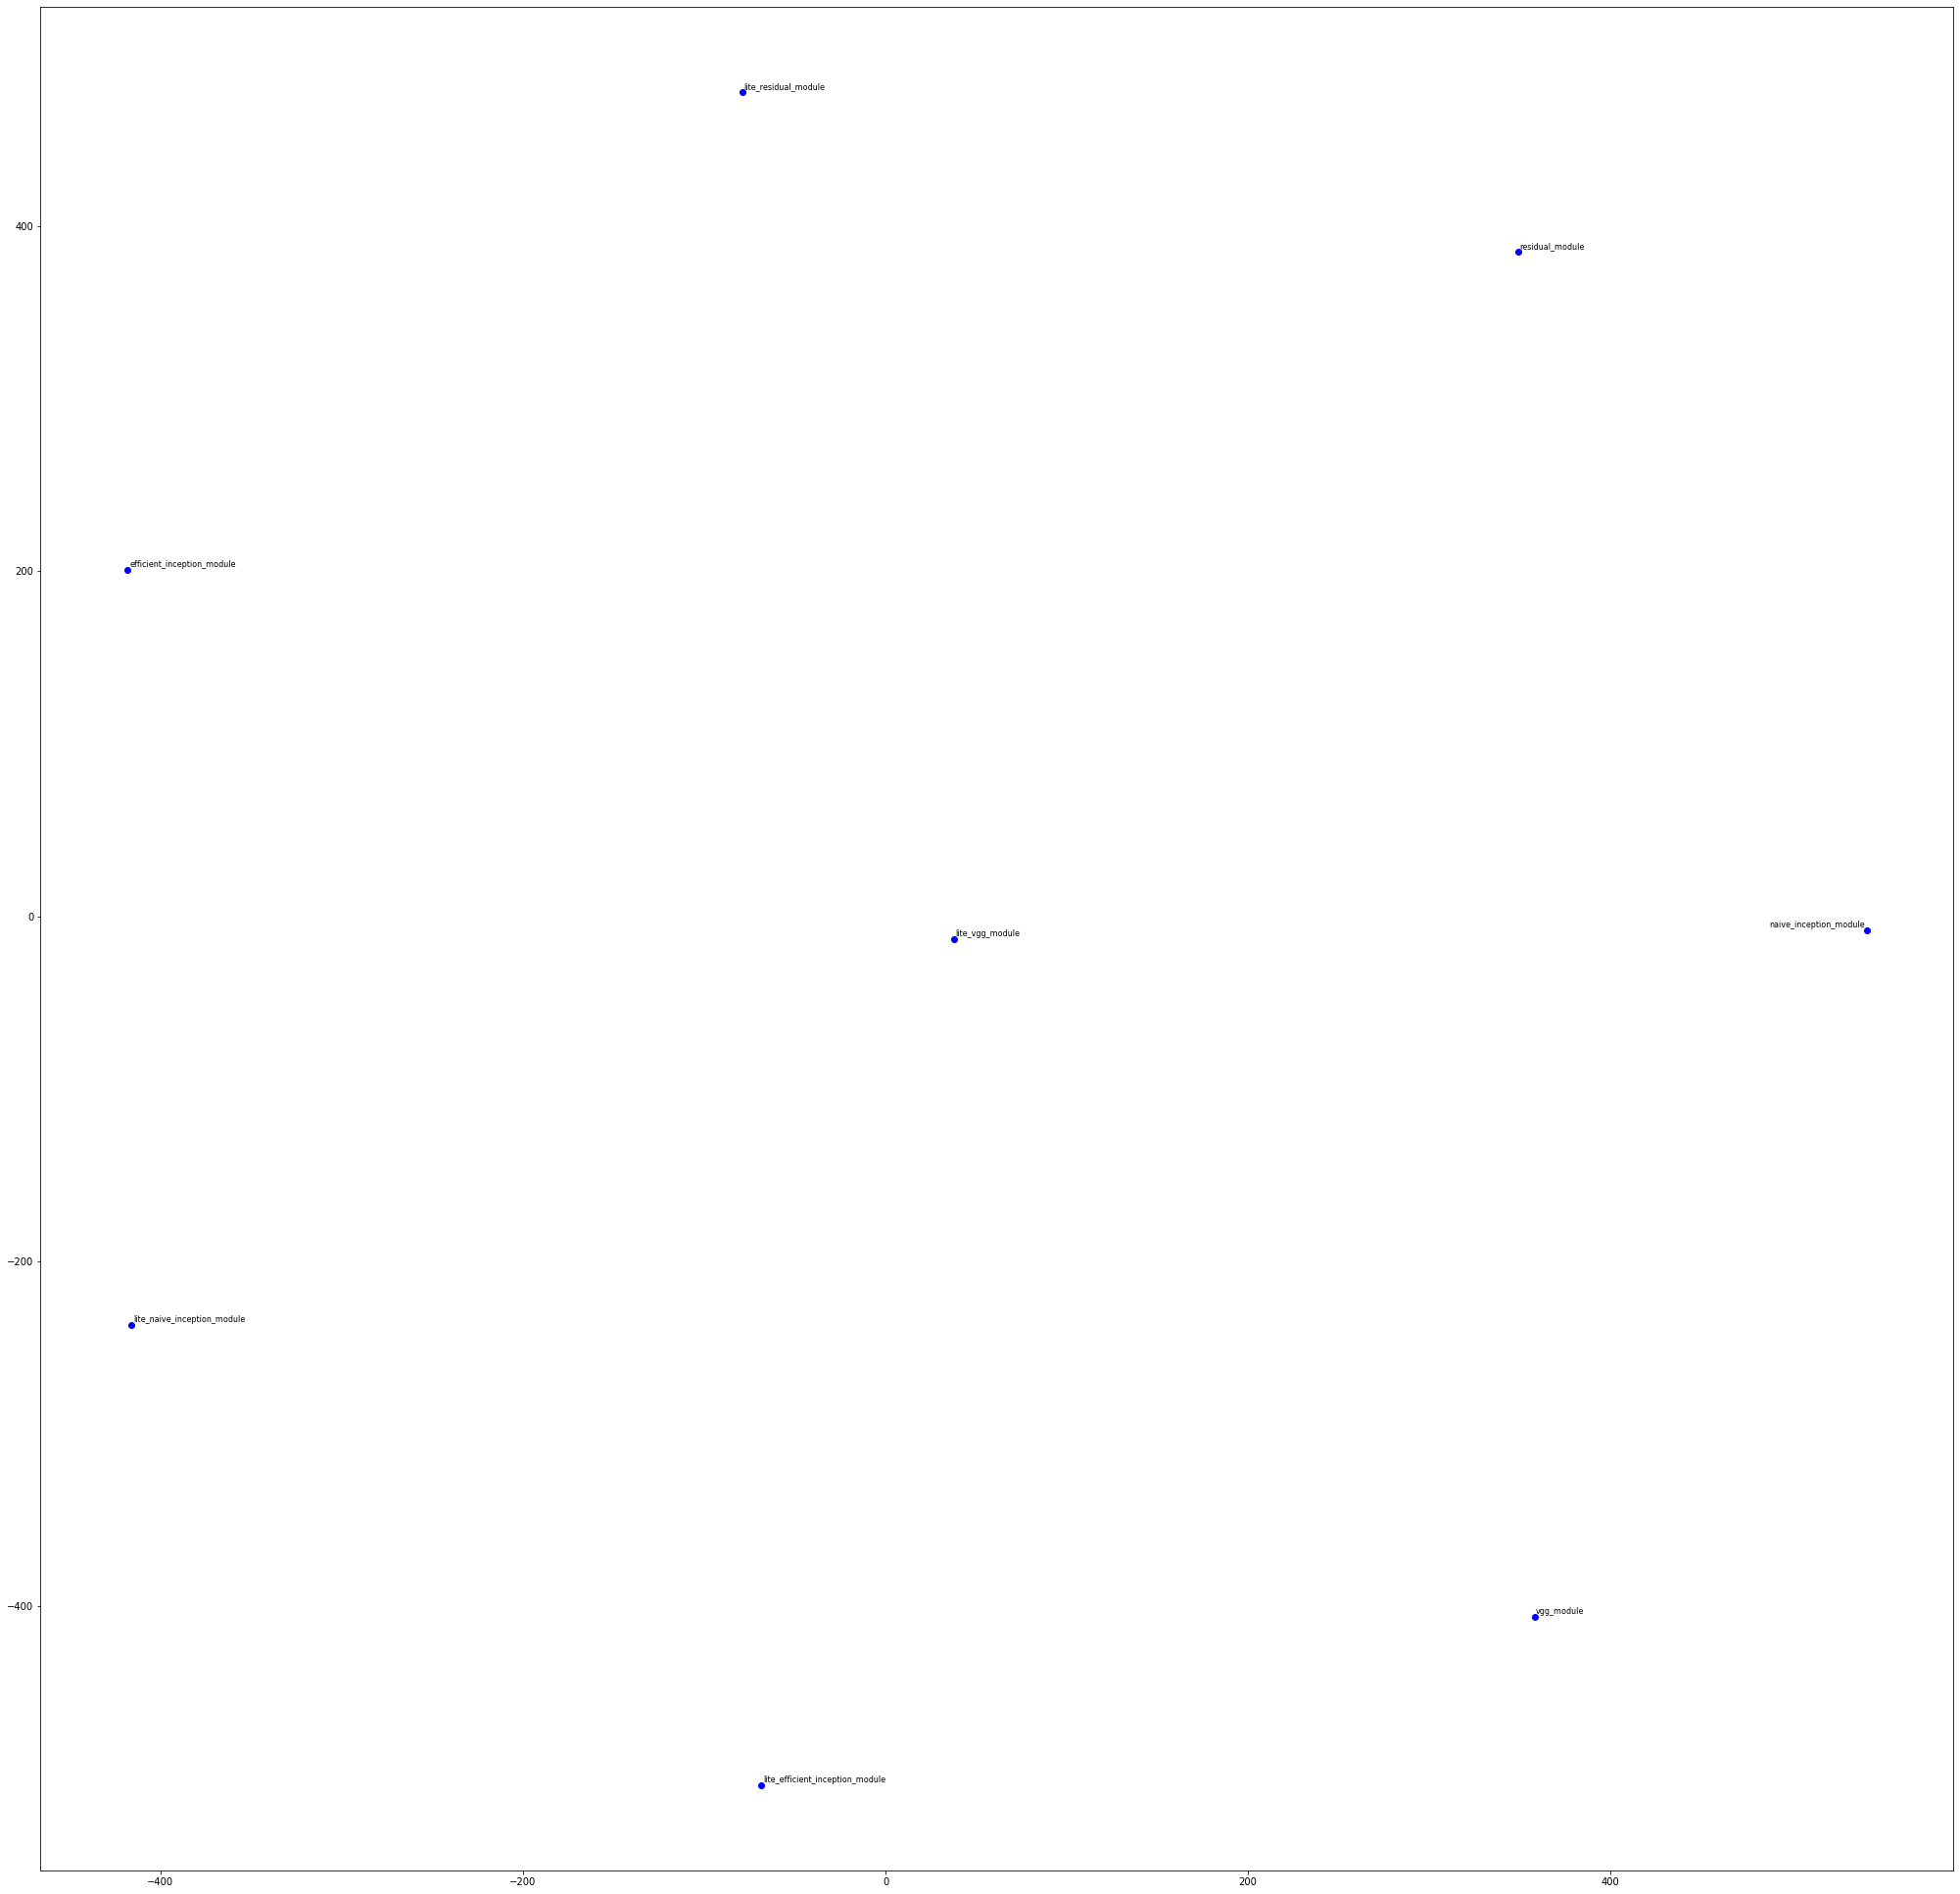

In [22]:
labels = list(embeddings_data.keys())
embeddings = list(embeddings_data.values())

tsne_model = TSNE()
new_embeddings = tsne_model.fit_transform(embeddings)

x = list()
y = list()

for embedding in new_embeddings:
    x.append(embedding[0])
    y.append(embedding[1])
    
fig, ax = plt.subplots(figsize = (35, 35))
plt.plot(x, y, 'bo')
texts = [plt.text(x[i], y[i], labels[i], fontsize = 8) for i in range(len(x))]
adjust_text(texts)

plt.savefig("/home/shobhitbehl/plot.png")
plt.show()